In [112]:
%load_ext autoreload
%autoreload 2
from unusual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from PIL import Image
# pyocr is a wrapper for tesseract, remember to install it!
import pyocr
import pyocr.builders
import io
import re
import glob
import pandas as pd
import numpy as np
from dask.delayed import delayed
import dask.dataframe as dd
from dask.diagnostics import ProgressBar, Profiler
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## Download PDF Files

Download the PDF for one of these, and add it to `{root_dir}/data/`:
- https://babel.hathitrust.org/cgi/pt?id=loc.ark:/13960/t3xs70k06
- https://babel.hathitrust.org/cgi/pt?id=loc.ark:/13960/t84j1sb5j

This make take a while, so remember to save it!

# Identifying and Processing Definitions

## Prep 
PDF converted to images with imagemagick in the command line. i.e. 

```
parallel --eta convert -density 200 loc-ark--13960-t3xs70k06-1644613654.pd.pdf[{}] pages/dictionary-{}.png ::: {0..1290}
```

I manually culled non-definition pages. Specifically: 

```bash
parallel mv pages/dictionary-{}.png nondef_pages/ ::: {0..24} 109 110 265 266 271 272 341 342 363 364 439 440 787 788 {1273..1290}
```

## Pre-processing

In [21]:
paths =glob.glob('../data/pages/dictionary-*.png')
# Pull out numbers, for easier sorting
nums = sorted([int(re.findall("\d+", path)[0]) for path in paths])

In [ ]:
tool = pyocr.get_available_tools()[0]
linebuilder = pyocr.builders.LineBoxBuilder()

In [4]:
def parse_page_df(num, path_pattern='../data/pages/dictionary-{}.png'):
    '''
    Process hOCR for a page and return the information as a DataFrame
    '''
    path = path_pattern.format(num)
    img_file = Image.open(path)
    line_boxes = tool.image_to_string(img_file, lang='eng', builder=linebuilder)
    content = [(num, i, lb.content, *lb.position[0], *lb.position[1]) for i, lb in enumerate(line_boxes)]
    return pd.DataFrame(content, columns=['pagenum', 'linenum', 'text', 'left', 'top', 'right', 'bottom'])

page = parse_page_df(565, '../data/pages/dictionary-{}.png')
page[20:24]

,pagenum,linenum,text,left,top,right,bottom
20,565,20,"59,436 sq. in.",110,432,248,448
21,565,21,try in Asia.,109,454,224,470
22,565,22,"GEORGIAN (iar’ien). ""-",85,469,379,492
23,565,23,Memher o! a pure Cam:-,109,498,362,514


In [7]:
def infer_page_details(df):
    '''
    Take a page DF of line information and add info on whether the line should
    # be ignored, what it's width is, and whether it looks like the start of 
    a definition.
    '''
    df['ignore'] = False
    df['width'] = df['right'] - df['left']
    df['height'] = df['bottom'] - df['top']

    # If there's a 1000+ pixel line in the first/last 40 lines, ignore everything before/after it
    startplace = df.query('width > 1000 & linenum < 40')['linenum'].max()
    maxline = df['linenum'].max() - 40
    endplace = df.query('width > 1000 & linenum > %d' % maxline)['linenum'].min()
    df.loc[(df['linenum'] <= startplace) | (df['linenum'] >= endplace), 'ignore'] = True

    # Ignore any other 1000+ pixel boxes
    df.loc[((df['width'] >= 1000) | (df['height'] >= 1000)), 'ignore'] = True
    
    # Ignore column headers
    df.loc[df['text'].str.match("^[A-Z\-\—]{2,}$"), "ignore"] = True

    # Ignore some watermarks that got through
    df.loc[df['text'].str.contains('ss_use|13960|ﬂhdl|22 GMT|rgfacce|Generated on |pd \\n|^Public Domain|Scotch.*owl'), 'ignore'] = True
    df.loc[(df['width'] < 40) & (df['height'] <40) & (df['text'] != ""), "ignore"] = True
    
    # Identify lines that seem to be the start of a definition: all caps, no on an ignored line,
    # and not ANT. or SYN.
    synonym = df['text'].str.startswith('SYN.')
    antonym = df['text'].str.startswith('ANT.')
    # Starts with 2+ Capital letters, eventually has a open '(' or (if the first was mis-OCR'd) a ')'
    start_def_match = df.text.str.match("^[A-Z\-\—]{2,}.*[\(\)]")
    df['def_start'] = (start_def_match & ~(synonym | antonym) & ~df['ignore'])
    
    # Identify column groups based on how much a line's left margin deviates from the previous line
    df['coldiff'] = df['left'] - df['left'].shift(1)
    df['col_group'] = (df['coldiff'].abs() > 400).cumsum()
    
    # Filter full columns, where the majority of rows are already set to ignore, or there are very few lines, 
    # or the mean width is very narrow
    def col_filter(x):
        if x['width'].mean() < 110:
            return True
        elif len(x) <= 3:
            return True
        elif x['ignore'].astype(int).mean() > 0.5:
            return True
        else:
            return False

    ignore_cols = df.groupby('col_group').apply(col_filter)
    ignore_col_groups = ignore_cols[ignore_cols].index.values
    df.loc[df['col_group'].isin(ignore_col_groups), 'ignore'] = True
    
    # Identify possible illustrations and their captions
    df['possible_pic'] = ((df['text'] == '') & 
                          (df['width'] < 600) &
                          (df['height'] < 600) &
                          ~df['col_group'].isin(ignore_col_groups))
    before_after_pic = (df['possible_pic'].shift(-1) | df['possible_pic'].shift(1)) & ~df['possible_pic']
    df["possible_caption"] = before_after_pic & df['text'].str.match("^[A-Z][\w\- ]{1,30}\.$")
    
    # Ignore illustrations. We'll pull them out later, and cross reference them to definitions on demand
    df.loc[df['possible_pic'] | df['possible_caption'], "ignore"] = True
    
    # Fix for column ordering: make sure the order is left-most, followed by top-down
    def renumber_cols(x):
        df = (x.groupby('col_group')
               .aggregate({'left': lambda x: np.floor(x.min() / 50), 'top': min})
               .sort_values(['left', 'top'])
               .copy()
              )
        df['new_col_group'] = df.index.to_series().sort_values().values
        df2 = pd.merge(x, df[['new_col_group']].reset_index(), on='col_group')
        df2.index = x.index
        return df2.drop('col_group', 1).rename(columns={'new_col_group': 'col_group'})

    df2 = renumber_cols(df)
    return df2.sort_values(['pagenum', 'col_group', 'linenum'])

details = infer_page_details(page)
details[20:22]

,pagenum,linenum,text,left,top,right,bottom,ignore,width,height,def_start,coldiff,possible_pic,possible_caption,col_group
20,565,20,"59,436 sq. in.",110,432,248,448,False,138,16,False,-261.0,False,False,2
21,565,21,try in Asia.,109,454,224,470,False,115,16,False,-1.0,False,False,2


In [9]:
path_pattern = '../data/pages/dictionary-{}.png'

In [71]:
delayed_dfs = []
for i in sorted(nums):
    page_hOCR = delayed(parse_page_df)(i, path_pattern)
    judged_df = delayed(infer_page_details)(page_hOCR)
    delayed_dfs.append(judged_df)
    
full_book_ddf = dd.from_delayed(delayed_dfs)

# Group together definition lines
full_book_ddf['word_group'] = full_book_ddf['def_start'].cumsum()

# Ensure no lines go over 400 chars
full_book_ddf['text'] = full_book_ddf['text'].apply(lambda x:x[:400])

with ProgressBar(), Profiler() as prof:
    a = full_book_ddf.to_hdf("dictionary.h5", "/full", complib='blosc', min_itemsize={'text':400})

[                                        ] | 0% Completed |  0.1s

/opt/conda/lib/python3.8/site-packages/dask/dataframe/core.py:3559: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'object'))

  warnings.warn(meta_warning(meta))


[########################################] | 100% Completed | 54.0s


If something changes in infer_page_details, you can re-do analysis without re-OCRing the pages

```allp = allp.groupby('pagenum', as_index=False).apply(infer_page_details)```

## Load the saved full-info DataFrame

In [79]:
allp = dd.read_hdf('dictionary.h5', 'full').compute()
allp.query('ignore != True')[::30000]

,pagenum,linenum,text,left,top,right,bottom,ignore,width,height,def_start,coldiff,possible_pic,possible_caption,col_group,word_group
5,127,5,"BARBATED (bar’ba-ted), u. Jagged with points;",112,128,602,145,False,490,17,True,-17.0,False,False,1,1
122,367,122,"of dectpto, deceiveJ",702,988,899,1005,False,197,17,False,0.0,False,False,2,8180
53,504,53,dlsclosure. [F'r.],213,1202,377,1219,False,164,17,False,24.0,False,False,1,2363
125,740,125,nuptials; espousals. ANT. Celibacy; vir-,739,1311,1182,1328,False,443,17,False,-24.0,False,False,1,10517
28,976,28,"EIGHT (rit), I. a. 1. Straight; most direct. 2.",148,661,635,677,False,487,16,True,-23.0,False,False,0,4772
72,1209,72,[A. S.,521,1363,575,1380,False,54,17,False,100.0,False,False,2,6294


In [81]:
def renumber_cols(x):
    df = (x.groupby('col_group')
           .aggregate({'left': lambda x: np.floor(x.min() / 50), 'top': min})
           .sort_values(['left', 'top'])
           .copy()
          )
    df['new_col_group'] = df.index.to_series().sort_values().values
    df2 = pd.merge(x, df[['new_col_group']].reset_index(), on='col_group')
    df2.index = x.index
    return df2.drop('col_group', 1).rename(columns={'new_col_group': 'col_group'})

allp = allp.groupby('pagenum', as_index=False).apply(renumber_cols).sort_values(['pagenum', 'col_group', 'linenum'])

In [86]:
allp.query('(pagenum >= 565) & (pagenum <= 570)').groupby('word_group').filter(lambda x: (x.pagenum.max()-x.pagenum.min()) > 1)

,,pagenum,linenum,text,left,top,right,bottom,ignore,width,height,def_start,coldiff,possible_pic,possible_caption,word_group,col_group


In [87]:
allp['word_group'] = allp['def_start'].cumsum()

In [88]:
allp[allp.text.str.contains('gaw', case=False)]

pagenum  linenum                                            text  \
88   38       115       38           SYN. Gawky: boorish: uncouth: clumsy;   
107  125      134      125  BAUBLE (ba’bl). n. 1. Piece of tinsel; gewgaw;   
524  89       561       89                               GAWK (gak). 7h 1-   
     95       561       95       GAVVK (gak), 11i- [prqh GAWK’ING; pd. and   
     96       561       96            p.p. GAWKED (gaklM Behave in a gawky   
     98       561       98                     GAW'KINESS (gall i—ncs), n.   
     99       561       99                                          gawky.   
     102      561      102   ler (gap), vi. [pr.p. GAWP’ING; 1m. and p.11.   
     103      561      103        GAWPED (gapOJ 1. Stare ina dazed manner,   
535  77       572       77                                    (A. S. gawk]   
636  22       673       22        gawk—Itching palm, grasping disposition;   
687  45       724       45        (tulli‘tl loaf. [Duh lotf, weather-gawk]   
780  17       819       17         ORGANIC (ar-gan’ik). ORGANICAL (gr-gaw-   
979  145     1018      145                                ingawmati seeds.   
1057 124     1096      124  STOP-GAP (stop’gaw. it. That nhich ﬁlls a gap.   

          left   top  right  bottom  ignore  width  height  def_start  \
88   38    165   775    585     791   False    420      16      False   
107  125   716  1373   1208    1389   False    492      16       True   
524  89    659   410    873     427   False    214      17       True   
     95    660   455   1149     473   False    489      18       True   
     96    684   476   1150     495   False    466      19      False   
     98    660   521    952     538   False    292      17       True   
     99    684   545    754     561   False     70      16      False   
     102   660   609   1148     628   False    488      19      False   
     103   685   632   1149     649   False    464      17       True   
535  77    761   190    884     208   False    123      18      False   
636  22    147   510    616     531   False    469      21      False   
687  45    212  1082    598    1101   False    386      19      False   
780  17     81   386    573     403   False    492      17       True   
979  145   750  1350    940    1366   False    190      16      False   
1057 124   700  1220   1191    1237   False    491      17       True   

          coldiff  possible_pic  possible_caption  word_group  col_group  
88   38      25.0         False             False        3107          1  
107  125    -24.0         False             False        3817          1  
524  89     -24.0         False             False       18572          3  
     95    -217.0         False             False       18573          3  
     96      24.0         False             False       18573          3  
     98     -24.0         False             False       18574          3  
     99      24.0         False             False       18574          3  
     102    -24.0         False             False       18575          3  
     103     25.0         False             False       18576          3  
535  77       0.0         False             False       18966          5  
636  22       0.0         False             False       22520          1  
687  45      -1.0         False             False       24133          1  
780  17       0.0         False             False       27065          1  
979  145     23.0         False             False       34028          8  
1057 124    -24.0         False             False       36895          1

In [91]:
allp.query('(pagenum>=565) & (word_group >= 17070)').iloc[50:]

pagenum  linenum                                               text  \
528  50       565       50            [Adapted from the native African llama]   
     51       565       51       GERM (jinn). n. 1. Rudimentary form at a new   
     52       565       52                                   plant or animal.   
     53       565       53                                    2. Origin; ﬁrst   
     54       565       54                                  prlnciple. 3. Mi-   
...           ...      ...                                                ...   
1233 134     1272      134                                      One versed in   
     135     1272      135                                                      
     136     1272      136  tine, tat, task, tar, fail,“ rare, above: mé. ...   
     137     1272      137  11:71, in Scotch gude,’ oil, owl. men, kh It i...   
     0       1272        0                                          ZODPHORIC   

          left   top  right  bottom  ignore  width  height  def_start  \
528  50    108  1054    530    1071   False    422      17      False   
     51     82  1079    575    1096   False    493      17       True   
     52    105  1101    264    1117   False    159      16      False   
     53    105  1123    265    1139   False    160      16      False   
     54    105  1146    264    1162   False    159      16      False   
...        ...   ...    ...     ...     ...    ...     ...        ...   
1233 134  1059   924   1210     938   False    151      14      False   
     135   906  1458    914    1462    True      8       4      False   
     136   187  1525   1188    1544    True   1001      19      False   
     137   410  1541    961    1558    True    551      17      False   
     0     895    55   1031      70    True    136      15      False   

          coldiff  possible_pic  possible_caption  word_group  col_group  
528  50       1.0         False             False       18702          2  
     51     -26.0         False             False       18703          2  
     52      23.0         False             False       18703          2  
     53       0.0         False             False       18703          2  
     54       0.0         False             False       18703          2  
...           ...           ...               ...         ...        ...  
1233 134   -105.0         False             False       43170          1  
     135   -153.0          True             False       43170          1  
     136   -719.0         False             False       43170          2  
     137    223.0         False             False       43170          2  
     0        NaN         False             False       43170          3  

[106656 rows x 16 columns]

## Combine definitions

In [206]:
definitions = allp.query('ignore != True')\
                  .groupby(['word_group', 'col_group', 'pagenum'], as_index=False).agg({
                                'text': lambda x: ' \n '.join(x.tolist()),
                                'left':'min',
                                'top':'min',
                                'right':'max',
                                'bottom':'max',
                                'linenum': lambda x: str((min(x), max(x))) # as str for hdfstore support
                               })\
                 .query('(right-left)<1000')\
                 .sort_values(['word_group', 'pagenum', 'col_group'])

definitions.sample(4)

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum
29935,29025,1,877,"PLASTIC (plas’tik), a. 1. Having power IA) gi ...",93,269,584,332,"(7, 9)"
36460,35387,2,1055,SMARTNESS (smart‘nes). n. Quality or state of ...,119,969,613,1009,"(43, 44)"
37607,36506,2,1085,STANCHION (stan’shun). n. Upright beam used \n...,105,806,599,845,"(33, 34)"
4340,4243,2,145,"BERRYING (her’i-ing), a. Gathering berries, \n...",675,1433,1167,1472,"(134, 135)"


In [207]:
definitions['word'] = definitions['text'].str.findall("^[A-Z\-]{2,}[ \(\.]").apply(lambda x: x[0][:-1] if len(x) > 0 else "")
definitions.loc[(definitions['word'] == "SYN") | (definitions['word'] == "ANT"), "word"] = ""

# Drop when there was a word identified in the second row of a definition
definitions['part'] = definitions.groupby('word_group')['word'].transform(lambda x: range(1,1+len(x))).astype(int)
non_empty_second_rows = (definitions['part'] > 1) & (definitions['word'] != "")
definitions.loc[(non_empty_second_rows | non_empty_second_rows.shift(-1)), "word"] = ""

# check when the row above is a) starts *below* the current row b) is in the same column 
# c) on the same page d) has a similar left value
#
starts_early = ((definitions.top < definitions.top.shift(1)) & 
                (definitions.col_group == definitions.shift(1).col_group) &
                (definitions.pagenum == definitions.shift(1).pagenum) &
                ((definitions.left - definitions.left.shift(1)).fillna(0).abs() < 10)
               )

# Set the top of those lines to the bottom of the previous line + 4
definitions.loc[starts_early, 'top'] = 4 + definitions.loc[starts_early.shift(-1).fillna(False).values].bottom.values

with pd.HDFStore('dictionary.h5') as store:
    store.append('/definitions', definitions)

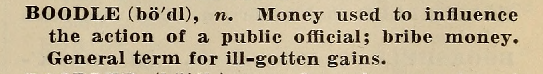

In [141]:
row = definitions[definitions.word.isin(oldslang.word)].sample(2).iloc[0]
img_from_row(row)

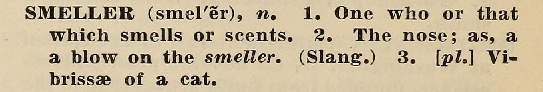

In [114]:
row = definitions[definitions.text.str.contains('smeller', case=False)].iloc[0]
img_from_row(row)

## Identify likely illustrations

In [ ]:
# Extract illustrations
illustrations_raw = allp[allp['possible_pic'] | allp['possible_caption']]
illustrations_raw['pic'] = (~(illustrations_raw['linenum']-1 == illustrations_raw['linenum'].shift(1))).cumsum()
illustrations = illustrations_raw.groupby(['pagenum', 'col_group', 'pic'], as_index=False)\
                                 .agg({'left':min, 'top': min, 'right':max, 'bottom':max})\
                                 .query('((right-left) >15) & ((bottom-top) >15) & ((right-left) <1000) & ((bottom-top) < 1000)')
illustrations.sample(3)

with pd.HDFStore('./dictionary.h5', mode='a') as store:
    store.append('/illustrations', illustrations)

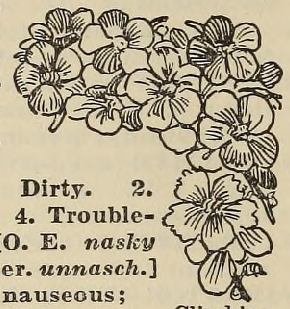

In [ ]:
img_from_illustration(illustrations.sample().iloc[0])

In [193]:
testrow = definitions.iloc[[365]]
testrow

,word_group,col_group,pagenum,text,left,top,right,bottom,linenum,word,part
369,359,1,35,"ACQUISITIVE (ak~kwiz’i-tlv), a. Desirous of \n...",112,1174,605,1214,"(52, 53)",ACQUISITIVE,1


In [ ]:
worddef = testrow[['pagenum', 'left', 'top', 'right', 'bottom']].values[0]
pad = 100
corners = []
for h in worddef[1::2]:
    for v in worddef[2::2]:
        hit = ((illustrations['pagenum'] == worddef[0]) & 
              (illustrations['left']-pad < h) & (illustrations['right']+pad > h) & 
              (illustrations['top']-pad < v) & (illustrations['bottom']+pad > v))
        corners.append(hit)

pic_matches = pd.concat(corners, axis=1).any(axis=1)
illustrations[pic_matches]

,pagenum,col_group,pic,left,bottom,right,top


In [ ]:
illustrations.sample(1).iloc[0].to_frame().T

,pagenum,col_group,pic,left,bottom,right,top
1067,1072,1,1057,1243,846,1466,413


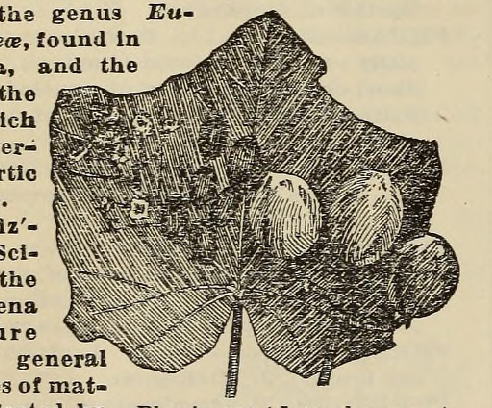

In [ ]:
img_from_match(illustrations.sample(1))

## Save all illustrations to disk

In [195]:
!mkdir -p ../data/illustration_images/

In [ ]:
img_from_match(illustrations.sample(1))

i = len(illustrations)
for i, match in illustrations.iterrows():
    img = img_from_illustration(match)
    img.save("../data/illustration_images/{}.png".format(i))
    i -= 1
    if i % 10 == 0:
        print(i)

In [208]:
# Rewriting updated stores
with pd.HDFStore('./dictionary.h5', mode='w') as store:
    store.append('/definitions', definitions)
    store.append('/full', allp)
    store.append('/illustrations', illustrations)

# Uncommon Words

Before writing 

To overcome OCR issues, I'll cross reference the list of definitions that I found with HathiTrust's OCR for two copies of this book. This will still leaves ample definitions. To identify "uncommon", I cross-referenced the list with the 700k most common words in the HathiTrust.

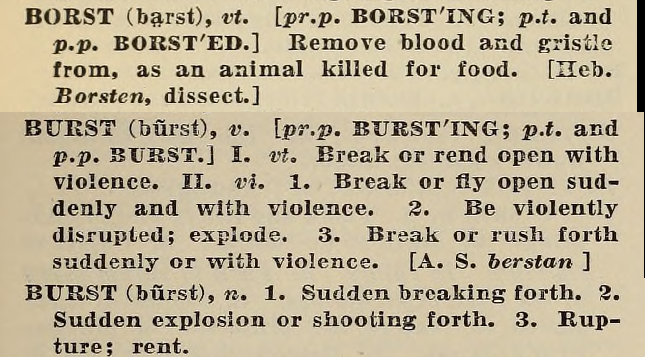

In [ ]:
match = query_definitions("BURST")
img_from_match(match)

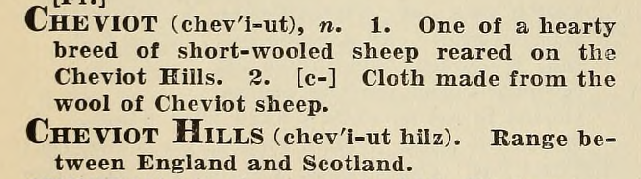

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(b)
img_from_match(match)

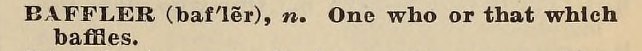

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

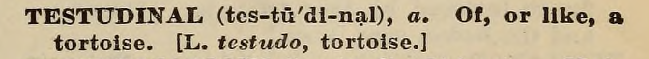

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

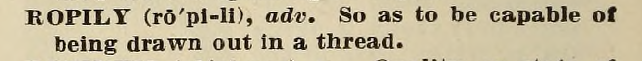

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

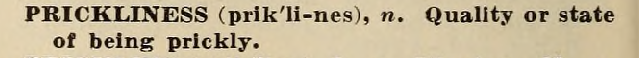

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)

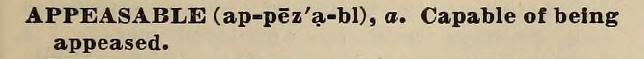

In [ ]:
word = uncommonwords.sample().values[0]
match = query_definitions(word)
img_from_match(match)